# PARAFAC2 - common pathways

- implementing parafac2 decomposition on the covid-19 dataset, common pathways only

In [5]:
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import tensorly as tl
import pickle
from tensorly.decomposition import parafac2
import tlviz
import pathintegrate
from evaluation_metrics import degeneracy_score_adapted, df_rank_evaluation
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from pathway_feature_selection import bootstrap_feature_select_pr2, feature_select_bs_ci, significant_pathways, harmonic_pvalue,combined_pseudoz, significant_pseudoz, plot_zscore_distribution

In [6]:
with open('common_pathways.pkl','rb') as f:
    common_pathways = pickle.load(f)

with open('metab_filtered_kpca.pkl','rb') as f:
    metab_filtered_kpca = pickle.load(f)

with open('prot_filtered_kpca.pkl','rb') as f:
    prot_filtered_kpca = pickle.load(f)

with open('metadata_binary.pkl','rb') as f:
    metadata_binary = pickle.load(f)


In [7]:
# Pre-processing: cen then bro

mat_to_be_processed = pd.concat([metab_filtered_kpca,prot_filtered_kpca],axis=1)

matrix_centered = mat_to_be_processed - mat_to_be_processed.mean()

from sklearn.preprocessing import scale
matrix_cen_bro = scale(matrix_centered,axis=1, with_mean=False)

trans_mat_cen_bro = matrix_cen_bro.T

metab_pr2_common = trans_mat_cen_bro[:60,:]
prot_pr2_common = trans_mat_cen_bro[60:,:]

In [8]:
trans_mat_cen_bro.shape

(120, 127)

In [9]:
print(metab_pr2_common.shape, prot_pr2_common.shape)

(60, 127) (60, 127)


In [10]:
def cal_rel_sse_slice(data, est_tensor, slice_index):
    """Calculate the rev metric for given data."""
    sum_squared = np.sum(data ** 2)
    sse = np.sum((data - est_tensor[slice_index]) ** 2)
    return (1 - sse / sum_squared) 

rel_metab_dict = {}
rel_prot_dict = {}

for rank in range(1, 11):

    parafac2_decomp = parafac2([metab_pr2_common, prot_pr2_common], init='svd', rank=rank)
    est_tensor = tl.parafac2_tensor.parafac2_to_slices(parafac2_decomp)

    rel_metab_dict[rank] = cal_rel_sse_slice(metab_pr2_common, est_tensor, 0)
    rel_prot_dict[rank] = cal_rel_sse_slice(prot_pr2_common, est_tensor, 1)

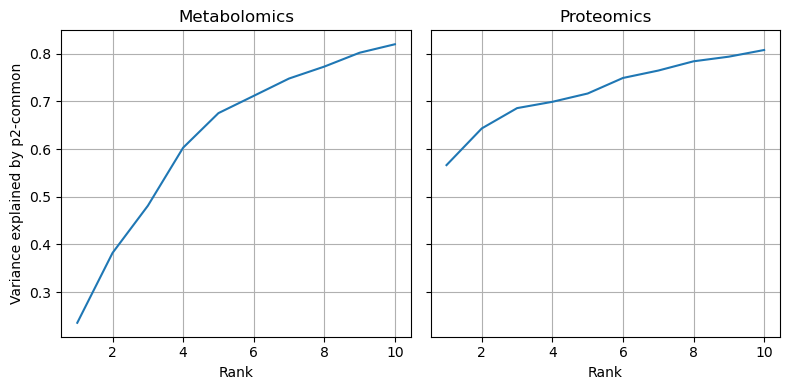

dict_values([0.2355679419828277, 0.38232104554749724, 0.4811863103531444, 0.6030589755193454, 0.6755638733015488, 0.7117589140659011, 0.748120518457712, 0.7731809130225795, 0.8022878116808736, 0.8200507322876276]) dict_values([0.566437992164368, 0.6434785920018152, 0.6860650967920279, 0.6992928077792739, 0.7167052719684754, 0.7493282901782081, 0.7648405193863346, 0.7842763751612166, 0.7940103119270832, 0.8079898458493917])


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.lineplot(x=rel_metab_dict.keys(),y=rel_metab_dict.values(),ax=ax1)
sns.lineplot(x=rel_prot_dict.keys(),y=rel_prot_dict.values(),ax=ax2)
ax1.set_title('Metabolomics')
ax1.set_xlabel('Rank')
ax1.set_ylabel('Variance explained by p2-common')
ax2.set_title('Proteomics')
ax2.set_xlabel('Rank')
ax1.grid(True)
ax2.grid(True)
plt.tight_layout()

plt.show()
print(rel_metab_dict.values(),rel_prot_dict.values())

In [12]:
tol_fit_dict = {}

metab_sum_squared = np.sum(metab_pr2_common ** 2)
prot_sum_squared = np.sum(prot_pr2_common ** 2)
sum_squared = metab_sum_squared + prot_sum_squared

for rank in range(1,11):
    parafac2_decomp = parafac2([metab_pr2_common, prot_pr2_common], init='svd', rank=rank)
    est_tensor = tl.parafac2_tensor.parafac2_to_slices(parafac2_decomp)
    sse_metab = np.sum((metab_pr2_common - est_tensor[0]) ** 2)
    sse_prot = np.sum((prot_pr2_common - est_tensor[1]) ** 2)
    sse = sse_metab + sse_prot
    tol_fit = (1 - sse / sum_squared) 
    tol_fit_dict[rank] = tol_fit

/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_40447/4259107973.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



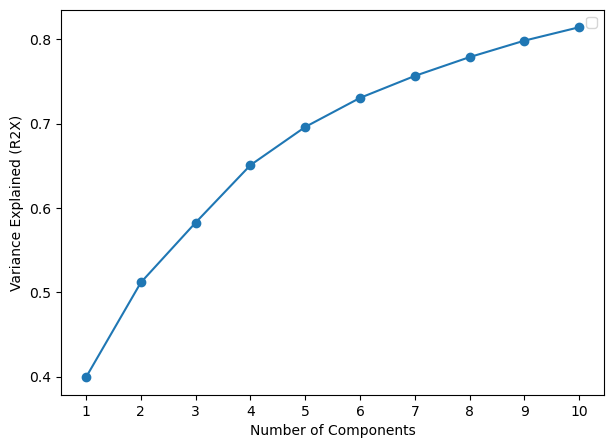

In [13]:
plt.figure(figsize=(7, 5))

plt.plot(tol_fit_dict.keys(), tol_fit_dict.values(),  marker='o')
plt.xticks(range(1,11))
plt.xlabel('Number of Components')
plt.ylabel("Variance Explained (R2X)")
plt.legend()


plt.show()

In [14]:
with open('p2_common_r2x_dict.pkl', 'wb') as f:
    pickle.dump(tol_fit_dict, f)

In [15]:
from tlviz.utils import normalise

def degeneracy_score_p2(p2_slices, max_rank):

    ds_dict = {}
    for rank in range(1,max_rank+1):
        cp_tensors = parafac2(p2_slices, rank,init='svd')
        weights, cp_factors, projections = cp_tensors
        factors = [cp_factors[1],cp_factors[0]]

        rank = factors[0].shape[1]
        tucker_congruence_scores = np.ones(shape=(rank, rank))
        if rank == 1:
            ds = 1
        else:
            for factor in factors:
                tucker_congruence_scores *= normalise(factor).T @ normalise(factor)
                print(tucker_congruence_scores)

        # update the diagonal to zero to skip it in the max search
            np.fill_diagonal(tucker_congruence_scores,0)

            ds = abs(np.asarray(tucker_congruence_scores)).max()

        ds_dict[rank] = ds
    ds_df = pd.DataFrame.from_dict(ds_dict,orient='index')
    return ds_df


In [16]:
ds_df = degeneracy_score_p2([metab_pr2_common,prot_pr2_common],10)

[[1.         0.06613854]
 [0.06613854 1.        ]]
[[1.        0.0615283]
 [0.0615283 1.       ]]
[[ 1.         -0.28395283  0.27385709]
 [-0.28395283  1.          0.33004392]
 [ 0.27385709  0.33004392  1.        ]]
[[ 1.         -0.27196432  0.17107199]
 [-0.27196432  1.          0.27156286]
 [ 0.17107199  0.27156286  1.        ]]
[[ 1.         -0.0289412   0.23046995 -0.44686058]
 [-0.0289412   1.          0.49474924 -0.3870189 ]
 [ 0.23046995  0.49474924  1.         -0.16069023]
 [-0.44686058 -0.3870189  -0.16069023  1.        ]]
[[ 1.         -0.02674356  0.14011749 -0.24714156]
 [-0.02674356  1.          0.42809647 -0.32104019]
 [ 0.14011749  0.42809647  1.         -0.16032474]
 [-0.24714156 -0.32104019 -0.16032474  1.        ]]
[[ 1.         -0.05775032  0.33854541 -0.37418188  0.12279099]
 [-0.05775032  1.          0.36520802 -0.26785158 -0.18421245]
 [ 0.33854541  0.36520802  1.         -0.09463516  0.23919204]
 [-0.37418188 -0.26785158 -0.09463516  1.         -0.21297696]
 [ 0

In [17]:
ds_df

,0
1,1.000000
2,0.061528
3,0.271964
4,0.428096
5,0.293783
6,0.328916
7,0.610896
8,0.496637
9,0.428012
10,0.454783


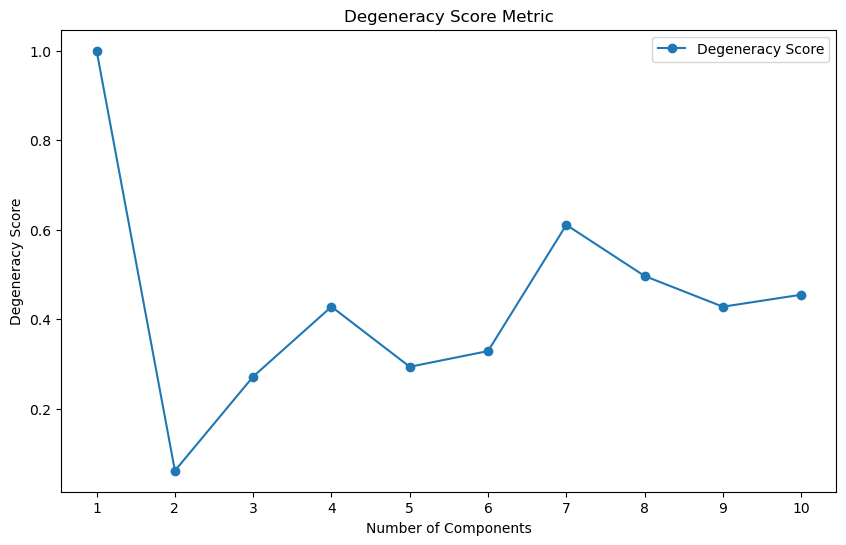

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(ds_df.index, ds_df.iloc[:,0], label='Degeneracy Score', marker='o')
plt.xticks(ds_df.index)
# Adding title and labels
plt.title('Degeneracy Score Metric')
plt.xlabel('Number of Components')
plt.ylabel('Degeneracy Score')
plt.legend()


plt.show()

In [19]:
parafac2_tensor_r2 = parafac2([metab_pr2_common,prot_pr2_common],init='svd',rank=2)
weights_r2, factors_r2, projections_r2 = parafac2_tensor_r2
omics_mat_r2,Sk_r2, sample_mat_r2 = factors_r2

In [20]:
len(projections_r2)

2

In [21]:
projections_r2[0].shape

(60, 2)

In [133]:
df_omics_r2 = pd.DataFrame(omics_mat_r2, index=['metab','prot'],columns=['Factor 1','Factor 2'])

Text(0.5, 1.0, 'p2-common Omics level factor matrix heatmap')

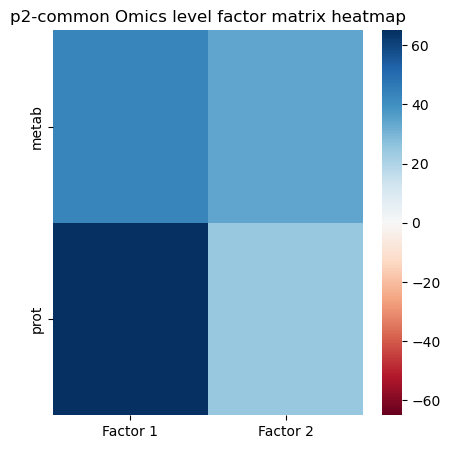

In [134]:
plt.figure(figsize=(5,5))
sns.heatmap(df_omics_r2, cmap='RdBu',vmin=-65,vmax=65)
plt.title('p2-common Omics level factor matrix heatmap')

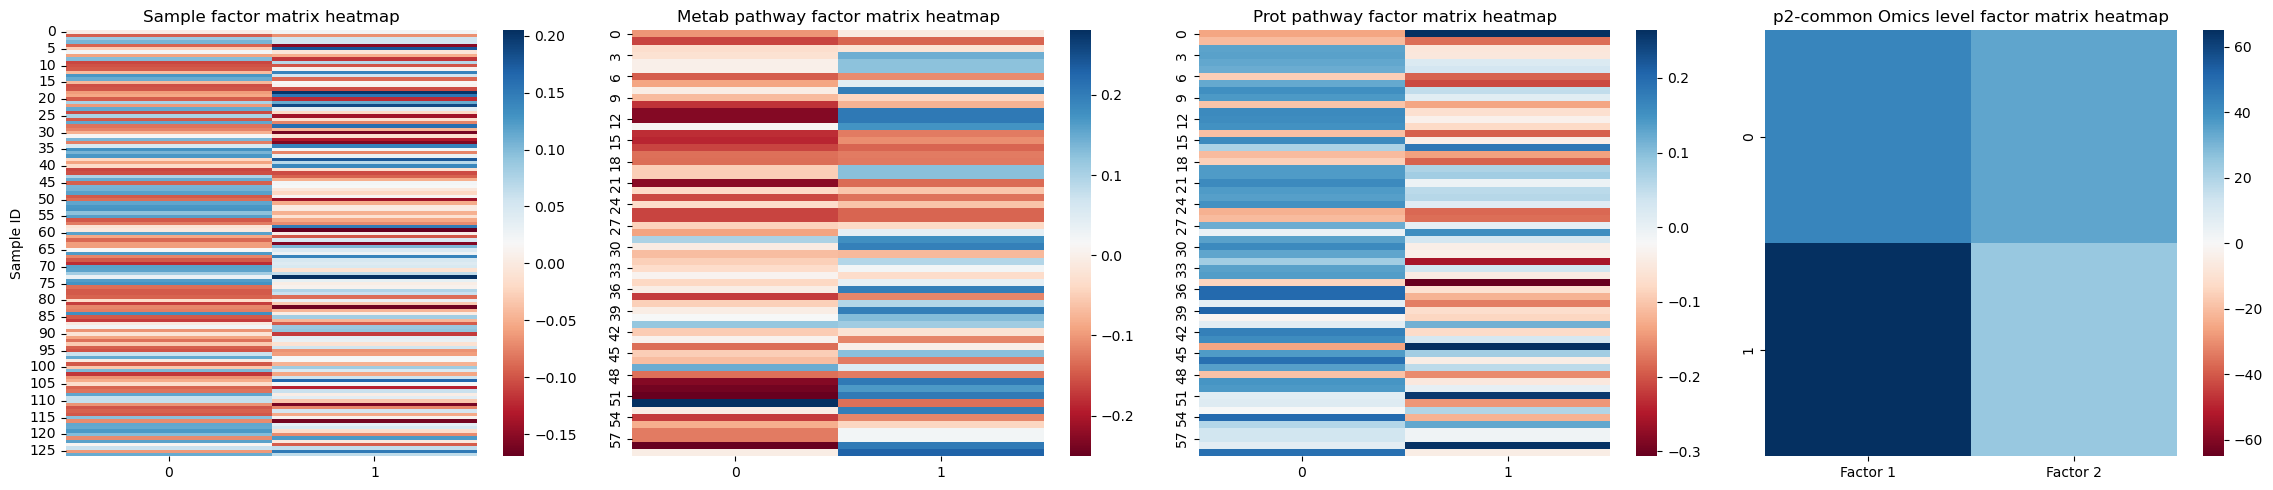

In [131]:
plt.figure(figsize=(23,5))

plt.subplot(1,4,1)
sns.heatmap(sample_mat_r2, cmap='RdBu')
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,4,2)
sns.heatmap(projections_r2[0], cmap='RdBu')
plt.title('Metab pathway factor matrix heatmap')

plt.subplot(1,4,3)
sns.heatmap(projections_r2[1], cmap='RdBu')
plt.title('Prot pathway factor matrix heatmap')

plt.subplot(1,4,4)
sns.heatmap(df_omics_r2, cmap='RdBu',vmin=-65,vmax=65)
plt.title('p2-common Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sample factor matrix heatmap')

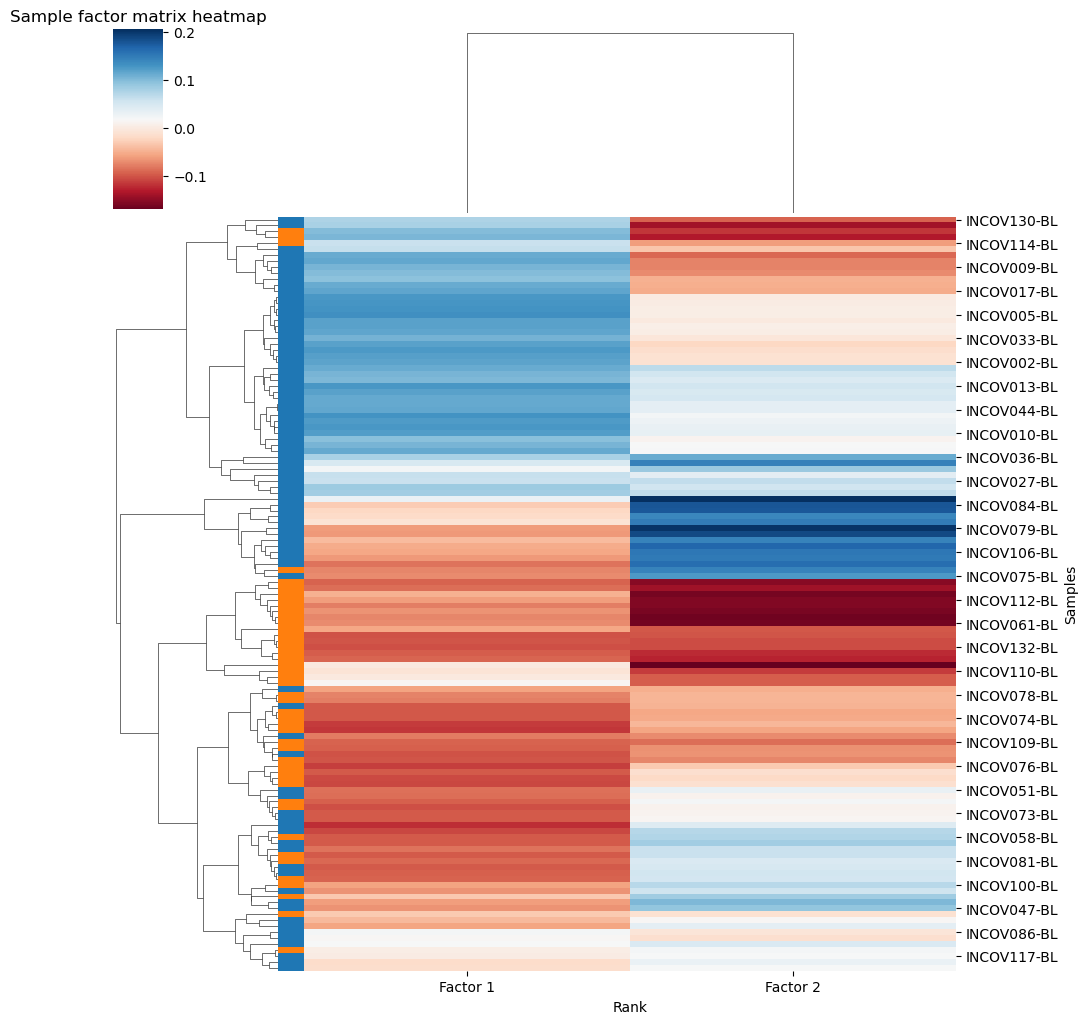

In [23]:
df_sample_r2 = pd.DataFrame(sample_mat_r2,index=metab_filtered_kpca.index, columns = [f"Factor {i}" for i in range(1,3)])
g=sns.clustermap(df_sample_r2, 
               cmap='RdBu', 
               row_colors=["tab:blue" if i ==1  else "tab:orange" for i in metadata_binary])
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Samples")
plt.title('Sample factor matrix heatmap')


In [24]:
with open('p2common_df_sample_r2.pkl', 'wb') as f:
    pickle.dump(df_sample_r2, f)

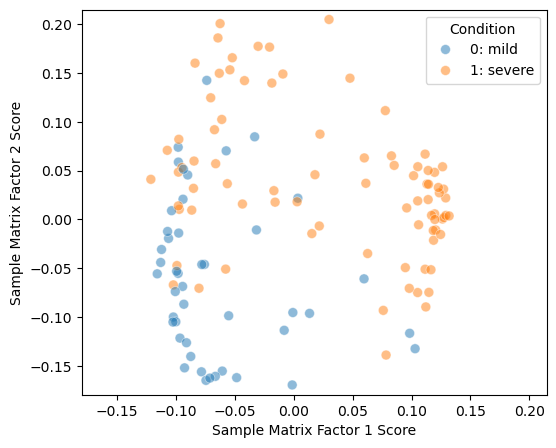

In [25]:
plt.figure(figsize=(6, 5))
g=sns.scatterplot(x=df_sample_r2.iloc[:, 0], y=df_sample_r2.iloc[:, 1], hue=metadata_binary,s=50,alpha=0.5)

# Add a title and labels if desired

plt.xlabel("Sample Matrix Factor 1 Score")
plt.ylabel("Sample Matrix Factor 2 Score")

# Determine the limits for the axes
limit_min = min(df_sample_r2.min()-0.01)
limit_max = max(df_sample_r2.max()+0.01)

# Ensure both axes have the same limits
plt.xlim(limit_min, limit_max)
plt.ylim(limit_min, limit_max)

handles = g.get_legend_handles_labels()[0]
labels = ['0: mild', '1: severe']
g.legend(handles=handles, labels=labels, title='Condition')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Metabolomics pathway factor matrix heatmap')

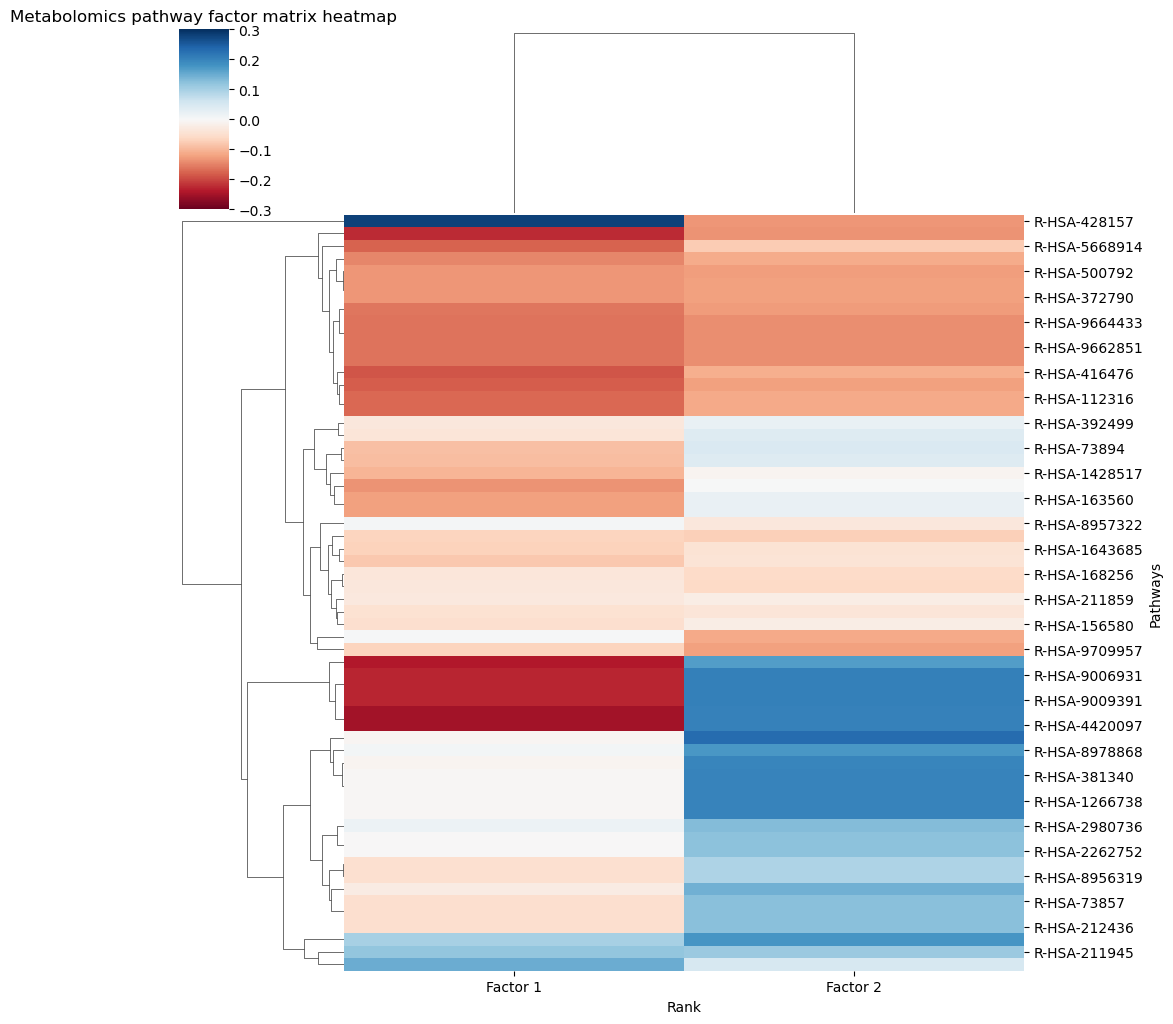

In [26]:
df_path_metab_r2 = pd.DataFrame(projections_r2[0],index=common_pathways,columns = [f"Factor {i}" for i in range(1,3)])
g=sns.clustermap(df_path_metab_r2, 
               cmap='RdBu',vmin=-0.3, vmax=0.3)
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Pathways")
plt.title('Metabolomics pathway factor matrix heatmap')

Text(0.5, 1.0, 'Proteomics pathway factor matrix heatmap')

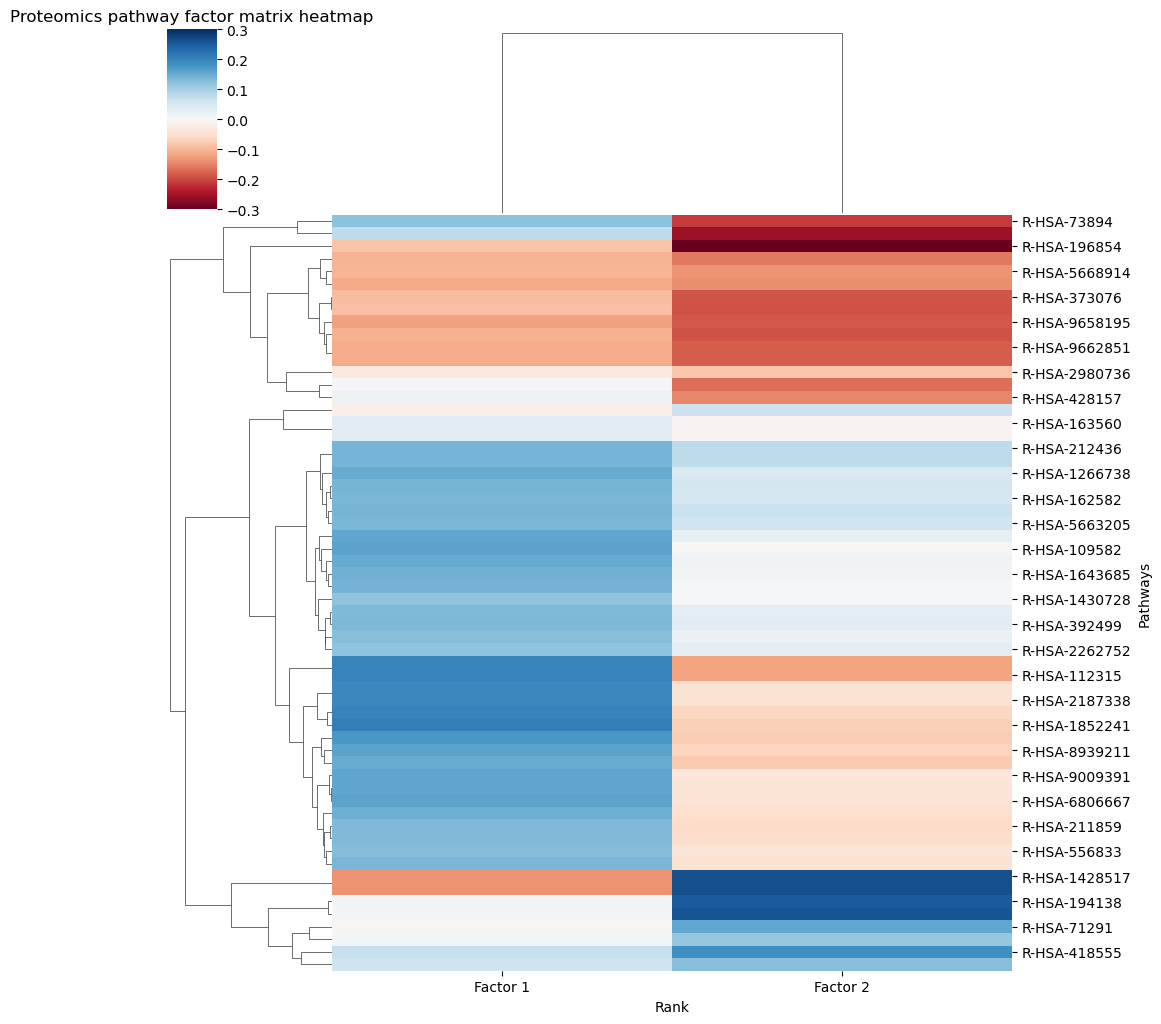

In [27]:
df_path_prot_r2 = pd.DataFrame(projections_r2[1],index=common_pathways,columns = [f"Factor {i}" for i in range(1,3)])
g=sns.clustermap(df_path_prot_r2, 
               cmap='RdBu',vmin=-0.3, vmax=0.3)
g.ax_heatmap.set_xlabel("Rank")
g.ax_heatmap.set_ylabel("Pathways")
plt.title('Proteomics pathway factor matrix heatmap')

In [145]:
with open('p2common_path_metab_r2.pkl', 'wb') as f:
    pickle.dump(df_path_metab_r2, f)

with open('p2common_path_prot_r2.pkl', 'wb') as f:
    pickle.dump(df_path_prot_r2, f)

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score

X = df_sample_r2  
y = metadata_binary  

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For both factors as features
f1_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

f1_uncorrected = np.mean(f1_scores)

# For factor 1
X_1 = df_sample_r2[['Factor 1']]
f1_scores_fac1 = []
for train_index, test_index in skf.split(X_1, y):
    X_train_1, X_test_1 = X_1.iloc[train_index], X_1.iloc[test_index]
    y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]
    
    model_1 = LogisticRegression()
    model_1.fit(X_train_1, y_train_1)
    
    y_pred_1 = model_1.predict(X_test_1)
    f1_fac1 = f1_score(y_test_1, y_pred_1)
    f1_scores_fac1.append(f1_fac1)

f1_fac1_uncorrected = np.mean(f1_scores_fac1)

# For factor 2
X_2 = df_sample_r2[['Factor 2']]
f1_scores_fac2 = []
for train_index, test_index in skf.split(X_2, y):
    X_train_2, X_test_2 = X_2.iloc[train_index], X_2.iloc[test_index]
    y_train_2, y_test_2 = y.iloc[train_index], y.iloc[test_index]
    
    model_2 = LogisticRegression()
    model_2.fit(X_train_2, y_train_2)
    
    y_pred_2 = model_2.predict(X_test_2)
    f1_fac2 = f1_score(y_test_2, y_pred_2)
    f1_scores_fac2.append(f1_fac2)

f1_fac2_uncorrected = np.mean(f1_scores_fac2)

print(f"F1 Score for both factors as feature: {f1_uncorrected:.2f}\n"
      f"F1 Score for factor 1: {f1_fac1_uncorrected:.2f}\n"
      f"F1 Score for factor 2: {f1_fac2_uncorrected:.2f} ")

F1 Score for both factors as feature: 0.78
F1 Score for factor 1: 0.78
F1 Score for factor 2: 0.78 


In [29]:
X = df_sample_r2  # Use both factor scores as feature
y = metadata_binary  # Binary target variable

# Create a stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
accuracy_list = []
roc_auc_list = []
f1_list = []

# Iterate over each fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE to the training data
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Create and fit the logistic regression model
    logreg = LogisticRegression()
    logreg.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = logreg.predict(X_test)
    y_pred_probs = logreg.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_probs)
    f1 = f1_score(y_test, y_pred)

    # Append metrics
    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    f1_list.append(f1)

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_list)
average_roc_auc = np.mean(roc_auc_list)
average_f1 = np.mean(f1_list)

print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")
print(f"Average F1 Score: {average_f1:.2f}")

Average Accuracy: 0.81
Average ROC AUC: 0.92
Average F1 Score: 0.85


In [30]:
X_1 = df_sample_r2[['Factor 1']]
y = metadata_binary 

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
roc_auc_list = []
f1_list = []

for train_index, test_index in skf.split(X_1, y):
    X_train_1, X_test_1 = X_1.iloc[train_index], X_1.iloc[test_index]
    y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_1, y_train_1)

    logreg_1 = LogisticRegression()
    logreg_1.fit(X_train_resampled, y_train_resampled)

    y_pred_1 = logreg_1.predict(X_test_1)
    y_pred_1_probs = logreg_1.predict_proba(X_test_1)[:, 1]
    
    accuracy = accuracy_score(y_test_1, y_pred_1)
    roc_auc = roc_auc_score(y_test_1, y_pred_1_probs)
    f1 = f1_score(y_test_1, y_pred_1)

    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    f1_list.append(f1)
    
average_accuracy = np.mean(accuracy_list)
average_roc_auc = np.mean(roc_auc_list)
average_f1 = np.mean(f1_list)

print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")
print(f"Average F1 Score: {average_f1:.2f}")

Average Accuracy: 0.70
Average ROC AUC: 0.81
Average F1 Score: 0.73


In [31]:
X_2 = df_sample_r2[['Factor 2']]  # Use Factor 2 as the feature
y = metadata_binary

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
roc_auc_list = []
f1_list = []

for train_index, test_index in skf.split(X_2, y):
    X_train_2, X_test_2 = X_2.iloc[train_index], X_2.iloc[test_index]
    y_train_2, y_test_2 = y.iloc[train_index], y.iloc[test_index]
    
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2, y_train_2)

    logreg_2 = LogisticRegression()
    logreg_2.fit(X_train_resampled, y_train_resampled)

    y_pred_2 = logreg_2.predict(X_test_2)
    y_pred_2_probs = logreg_2.predict_proba(X_test_2)[:, 1]

    accuracy = accuracy_score(y_test_2, y_pred_2)
    roc_auc = roc_auc_score(y_test_2, y_pred_2_probs)
    f1 = f1_score(y_test_2, y_pred_2)

    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    f1_list.append(f1)

average_accuracy = np.mean(accuracy_list)
average_roc_auc = np.mean(roc_auc_list)
average_f1 = np.mean(f1_list)

print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")
print(f"Average F1 Score: {average_f1:.2f}")

Average Accuracy: 0.77
Average ROC AUC: 0.82
Average F1 Score: 0.81


[0.7307692307692307, 0.6923076923076923, 0.8, 0.68, 0.6] [0.8431372549019607, 0.8562091503267975, 0.8958333333333334, 0.7777777777777778, 0.6805555555555556] [0.7586206896551724, 0.6923076923076923, 0.8148148148148148, 0.7142857142857143, 0.6875]
[0.7692307692307693, 0.6538461538461539, 0.72, 0.88, 0.84] [0.7712418300653595, 0.6928104575163399, 0.9027777777777778, 0.8194444444444445, 0.9305555555555556] [0.8125, 0.7272727272727273, 0.72, 0.9142857142857143, 0.875]
[0.8846153846153846, 0.7692307692307693, 0.8, 0.8, 0.8] [0.934640522875817, 0.8496732026143791, 0.9791666666666666, 0.9375, 0.9027777777777778] [0.9032258064516129, 0.8125, 0.8148148148148148, 0.8484848484848485, 0.8484848484848485]


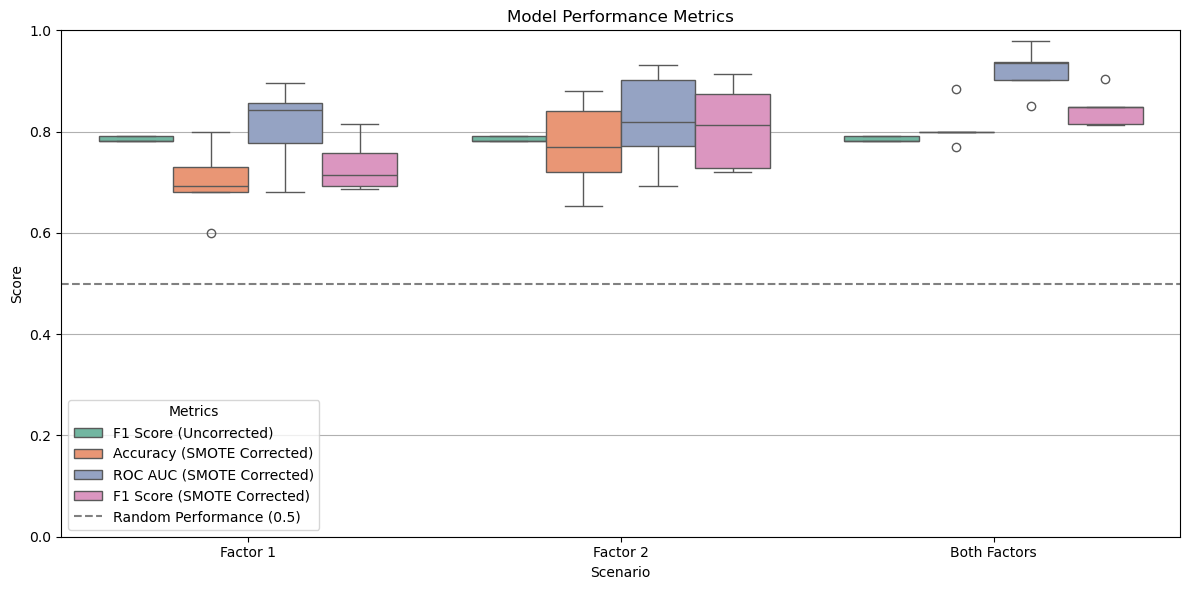

In [32]:
def compute_metrics(X, y, use_smote=False):
    accuracy_list = []
    roc_auc_list = []
    f1_list = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if use_smote:
            smote = SMOTE(sampling_strategy='minority', random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        model = LogisticRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_probs = model.predict_proba(X_test)[:, 1]

        accuracy_list.append(accuracy_score(y_test, y_pred))
        roc_auc_list.append(roc_auc_score(y_test, y_pred_probs))
        f1_list.append(f1_score(y_test, y_pred))

    return accuracy_list, roc_auc_list, f1_list

scenarios = {
    "Factor 1": df_sample_r2[['Factor 1']],
    "Factor 2": df_sample_r2[['Factor 2']],
    "Both Factors": df_sample_r2
}

metrics = {
    "Scenario": [],
    "Metric": [],
    "Score": []
}

for scenario_name, X in scenarios.items():
    y = metadata_binary
    
    f1_uncorrected = compute_metrics(X, y, use_smote=False)[2]

    for score in f1_uncorrected:
        metrics["Scenario"].append(scenario_name)
        metrics["Metric"].append("F1 Score (Uncorrected)")
        metrics["Score"].append(score)

    accuracy_smote, roc_auc_smote, f1_smote = compute_metrics(X, y, use_smote=True)
    
    print(accuracy_smote, roc_auc_smote, f1_smote)
    for score in accuracy_smote:
        metrics["Scenario"].append(scenario_name)
        metrics["Metric"].append("Accuracy (SMOTE Corrected)")
        metrics["Score"].append(score)

    for score in roc_auc_smote:
        metrics["Scenario"].append(scenario_name)
        metrics["Metric"].append("ROC AUC (SMOTE Corrected)")
        metrics["Score"].append(score)
        
    for score in f1_smote:
        metrics["Scenario"].append(scenario_name)
        metrics["Metric"].append("F1 Score (SMOTE Corrected)")
        metrics["Score"].append(score)

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Set up the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df, x='Scenario', y='Score', hue='Metric', palette='Set2')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.axhline(0.5, color='gray', linestyle='--', label='Random Performance (0.5)')
plt.legend(title='Metrics')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Reconstructing slices at rank = 2

In [33]:
recon_slices_r2 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r2)

In [34]:
matrix_cen_bro.shape

(127, 120)

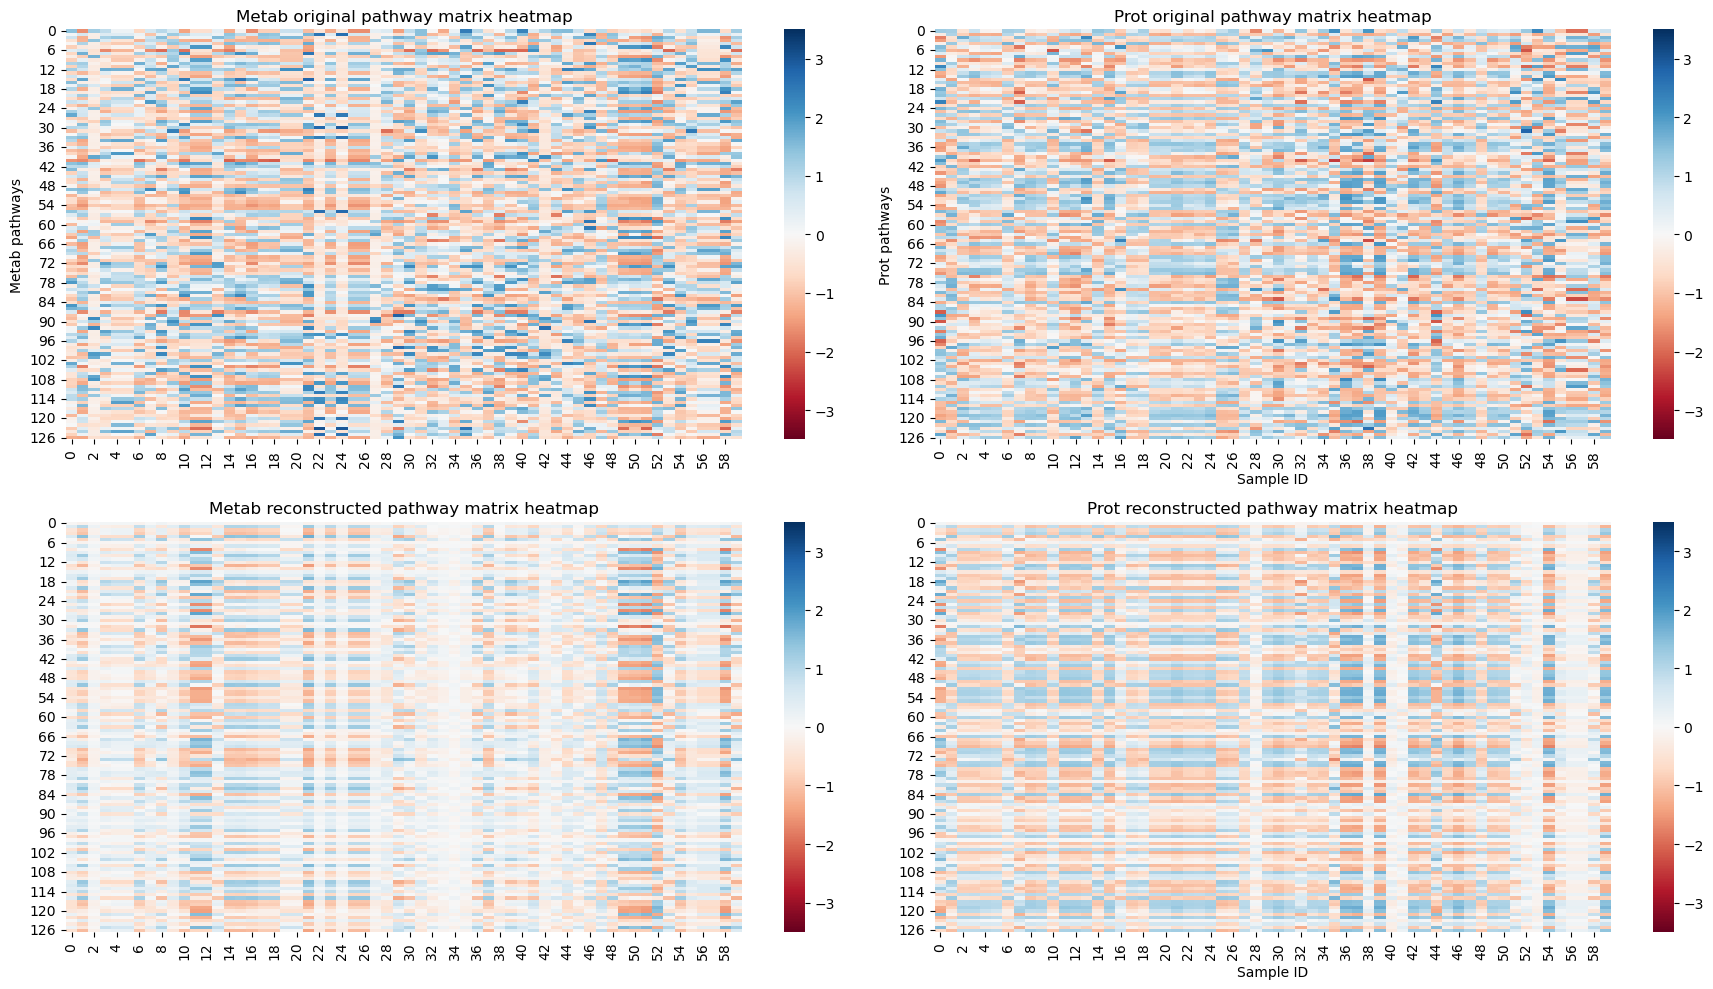

In [35]:
recon_slices_r2 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r2)
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.heatmap(matrix_cen_bro[:,:60], cmap='RdBu',vmax=3.5,vmin=-3.5)
plt.title('Metab original pathway matrix heatmap')
plt.ylabel('Metab pathways')

plt.subplot(2,2,3)
sns.heatmap(recon_slices_r2[0].T, cmap='RdBu',vmax=3.5,vmin=-3.5)
plt.title('Metab reconstructed pathway matrix heatmap')

plt.subplot(2,2,2)
sns.heatmap(matrix_cen_bro[:,60:], cmap='RdBu',vmax=3.5,vmin=-3.5)
plt.title('Prot original pathway matrix heatmap')
plt.ylabel('Prot pathways')
plt.xlabel('Sample ID')

plt.subplot(2,2,4)
sns.heatmap(recon_slices_r2[1].T, cmap='RdBu',vmax=3.5,vmin=-3.5)
plt.title('Prot reconstructed pathway matrix heatmap')
plt.xlabel('Sample ID')


plt.tight_layout()
plt.show()

#### Feature selection

In [36]:
path_facs_dfs = bootstrap_feature_select_pr2([metab_filtered_kpca,prot_filtered_kpca])

In [37]:
metab_fac1_bs = path_facs_dfs[0][0]
metab_fac2_bs = path_facs_dfs[0][1]
prot_fac1_bs = path_facs_dfs[1][0]
prot_fac2_bs = path_facs_dfs[1][1]

In [38]:
import plotly.graph_objects as go

pathway_num = metab_fac1_bs.shape[1]

fig = go.Figure()

# Plot mean pathway factor scores for Pathway Factor 1
metab_fac1_mean, metab_fac1_cis = feature_select_bs_ci(metab_fac1_bs)
fig.add_trace(go.Scatter(
    x=common_pathways,
    y=metab_fac1_mean,
    mode='markers',
    name='Mean Metab Pathway Factor 1 Score ± 95% CI',
    error_y=dict(type='data', array=metab_fac1_cis[:, 1]- metab_fac1_mean, arrayminus=metab_fac1_mean - metab_fac1_cis[:, 0]),
    text=metab_fac1_bs.columns,
    hoverinfo='text'
))

# Plot mean pathway factor scores for Pathway Factor 2
metab_fac2_mean, metab_fac2_cis = feature_select_bs_ci(metab_fac2_bs)
fig.add_trace(go.Scatter(
    x=common_pathways,
    y=metab_fac2_mean,
    mode='markers',
    name='Mean Metab Pathway Factor 2 Score ± 95% CI',
    error_y=dict(type='data', array=metab_fac2_cis[:, 1] - metab_fac2_mean, arrayminus=metab_fac2_mean-metab_fac2_cis[:, 0]),
    text=metab_fac2_bs.columns,
    hoverinfo='text'
))

fig.update_layout(
    title="Metab Pathway Factor Matrix Scores with 95% Confidence Intervals",
    xaxis_title="Pathways",
    yaxis_title="Pathway Factor Score",
    xaxis=dict(tickmode='linear'),  
    showlegend=True,
    width=1000,  
    height=600   
)

fig.show()

In [40]:
pathway_num = prot_fac1_bs.shape[1]

fig = go.Figure()

# Plot mean pathway factor scores for Pathway Factor 1
prot_fac1_mean, prot_fac1_cis = feature_select_bs_ci(prot_fac1_bs)
fig.add_trace(go.Scatter(
    x=common_pathways,
    y=prot_fac1_mean,
    mode='markers',
    name='Mean Prot Pathway Factor 1 Score ± 95% CI',
    error_y=dict(type='data', array=prot_fac1_cis[:, 1]- prot_fac1_mean, arrayminus=prot_fac1_mean - prot_fac1_cis[:, 0]),
    text=prot_fac1_bs.columns,
    hoverinfo='text'
))

# Plot mean pathway factor scores for Pathway Factor 2
prot_fac2_mean, prot_fac2_cis = feature_select_bs_ci(prot_fac2_bs)
fig.add_trace(go.Scatter(
    x=common_pathways,
    y=prot_fac2_mean,
    mode='markers',
    name='Mean Prot Pathway Factor 2 Score ± 95% CI',
    error_y=dict(type='data', array=prot_fac2_cis[:, 1] - prot_fac2_mean, arrayminus=prot_fac2_mean-prot_fac2_cis[:, 0]),
    text=prot_fac2_bs.columns,
    hoverinfo='text'
))

fig.update_layout(
    title="Prot Pathway Factor Matrix Scores with 95% Confidence Intervals",
    xaxis_title="Pathways",
    yaxis_title="Pathway Factor Score",
    xaxis=dict(tickmode='linear'),  
    showlegend=True,
    width=1000,  
    height=600   
)

fig.show()

In [42]:
metab_pathways  = sspa.process_reactome(organism="Homo sapiens")
metab_pathway_dict = dict(zip(metab_pathways.index,metab_pathways['Pathway_name'].to_list()))

- Second method to select significant pathways

In [43]:
metab_facs_bs = {0: metab_fac1_bs, 1: metab_fac2_bs}
prot_facs_bs = {0: prot_fac1_bs, 1: prot_fac2_bs}

In [44]:
with open('reactome_updated.pkl','rb') as f:
    prot_pathways = pickle.load(f)

prot_pathway_dict = dict(zip(prot_pathways.index,prot_pathways['Pathway_name'].to_list()))

In [45]:
p2_common_metab_pseudoz = combined_pseudoz(metab_facs_bs)

In [120]:
with open('p2_common_metab_pseudoz.pkl', 'wb') as f:
    pickle.dump(p2_common_metab_pseudoz, f)

In [135]:
p2_common_metab_f1_pseudoz = p2_common_metab_pseudoz[['Factor 1']].abs().sort_values(by='Factor 1',ascending=False)
p2_common_metab_f1_pseudoz=p2_common_metab_f1_pseudoz.rename(columns={'Factor 1':'Combined'})
p2_common_metab_f1_sigpath = significant_pseudoz(p2_common_metab_f1_pseudoz,metab_pathway_dict,95)
p2_common_metab_f1_sigpath

3 significant pathways ['R-HSA-428157', 'R-HSA-109582', 'R-HSA-9006934']


{'R-HSA-428157': 'Sphingolipid metabolism',
 'R-HSA-109582': 'Hemostasis',
 'R-HSA-9006934': 'Signaling by Receptor Tyrosine Kinases'}

In [136]:
p2_common_metab_f2_pseudoz = p2_common_metab_pseudoz[['Factor 2']].abs().sort_values(by='Factor 2',ascending=False)
p2_common_metab_f2_pseudoz=p2_common_metab_f2_pseudoz.rename(columns={'Factor 2':'Combined'})
p2_common_metab_f2_sigpath = significant_pseudoz(p2_common_metab_f2_pseudoz,metab_pathway_dict,95)
p2_common_metab_f2_sigpath

3 significant pathways ['R-HSA-9006931', 'R-HSA-8939211', 'R-HSA-9009391']


{'R-HSA-9006931': 'Signaling by Nuclear Receptors',
 'R-HSA-8939211': 'ESR-mediated signaling',
 'R-HSA-9009391': 'Extra-nuclear estrogen signaling'}

In [137]:
parafac2_common_metab_sigpath_dict = p2_common_metab_f1_sigpath | p2_common_metab_f2_sigpath

In [113]:
p2_common_prot_pseudoz = combined_pseudoz(prot_facs_bs)

In [121]:
with open('p2_common_prot_pseudoz.pkl', 'wb') as f:
    pickle.dump(p2_common_prot_pseudoz, f)

In [138]:
p2_common_prot_f1_pseudoz = p2_common_prot_pseudoz[['Factor 1']].abs().sort_values(by='Factor 1',ascending=False)
p2_common_prot_f1_pseudoz=p2_common_prot_f1_pseudoz.rename(columns={'Factor 1':'Combined'})
p2_common_prot_f1_sigpath = significant_pseudoz(p2_common_prot_f1_pseudoz,prot_pathway_dict,95)
p2_common_prot_f1_sigpath

3 significant pathways ['R-HSA-1643685', 'R-HSA-109582', 'R-HSA-168256']


{'R-HSA-1643685': 'Disease',
 'R-HSA-109582': 'Hemostasis',
 'R-HSA-168256': 'Immune System'}

In [139]:
p2_common_prot_f2_pseudoz = p2_common_prot_pseudoz[['Factor 2']].abs().sort_values(by='Factor 2',ascending=False)
p2_common_prot_f2_pseudoz=p2_common_prot_f2_pseudoz.rename(columns={'Factor 2':'Combined'})
p2_common_prot_f2_sigpath = significant_pseudoz(p2_common_prot_f2_pseudoz,prot_pathway_dict,95)
p2_common_prot_f2_sigpath

3 significant pathways ['R-HSA-388396', 'R-HSA-73894', 'R-HSA-196854']


{'R-HSA-388396': 'GPCR downstream signalling',
 'R-HSA-73894': 'DNA Repair',
 'R-HSA-196854': 'Metabolism of vitamins and cofactors'}

In [140]:
parafac2_common_prot_sigpath_dict = p2_common_prot_f1_sigpath | p2_common_prot_f2_sigpath

In [141]:
p2_common_sig_dict = parafac2_common_metab_sigpath_dict|parafac2_common_prot_sigpath_dict

In [142]:
with open('parafac2_common_metab_sigpath_dict.pkl', 'wb') as f:
    pickle.dump(parafac2_common_metab_sigpath_dict, f)
with open('parafac2_common_prot_sigpath_dict.pkl', 'wb') as f:
    pickle.dump(parafac2_common_prot_sigpath_dict, f)

In [68]:
with open('mw_metab.pkl','rb') as f:
    mw_metab = pickle.load(f)
with open('mw_prot.pkl','rb') as f:
    mw_prot = pickle.load(f)

In [103]:
mw_metab.loc[parafac2_common_metab_sigpath_dict.keys()]

,p_val
R-HSA-428157,4.443118e-08
R-HSA-162582,3.458714e-50
R-HSA-211945,1.932176e-44
R-HSA-9006931,1.501138e-02
R-HSA-8939211,1.501138e-02
R-HSA-9009391,1.501138e-02


In [104]:
mw_prot.loc[parafac2_common_metab_sigpath_dict.keys()]

,p_val
R-HSA-428157,2.572099e-46
R-HSA-162582,5.036970e-34
R-HSA-211945,1.284971e-01
R-HSA-9006931,7.480290e-20
R-HSA-8939211,4.322376e-21
R-HSA-9009391,8.954674e-77


In [105]:
mw_metab.loc[parafac2_common_prot_sigpath_dict.keys()]

,p_val
R-HSA-1643685,3.113905e-48
R-HSA-109582,4.717529e-39
R-HSA-168256,2.692290e-15
R-HSA-4420097,3.332979e-02
R-HSA-194138,3.332979e-02


In [106]:
mw_prot.loc[parafac2_common_prot_sigpath_dict.keys()]

,p_val
R-HSA-1643685,1.163892e-35
R-HSA-109582,3.493703e-52
R-HSA-168256,2.572099e-46
R-HSA-4420097,2.364704e-03
R-HSA-194138,2.362938e-07


In [109]:
mild_ind = []
severe_ind = []
for index in metadata_binary.index:
    if metadata_binary[index] == 0:
        mild_ind.append(index)
    else:
        severe_ind.append(index)

<Figure size 1500x500 with 0 Axes>

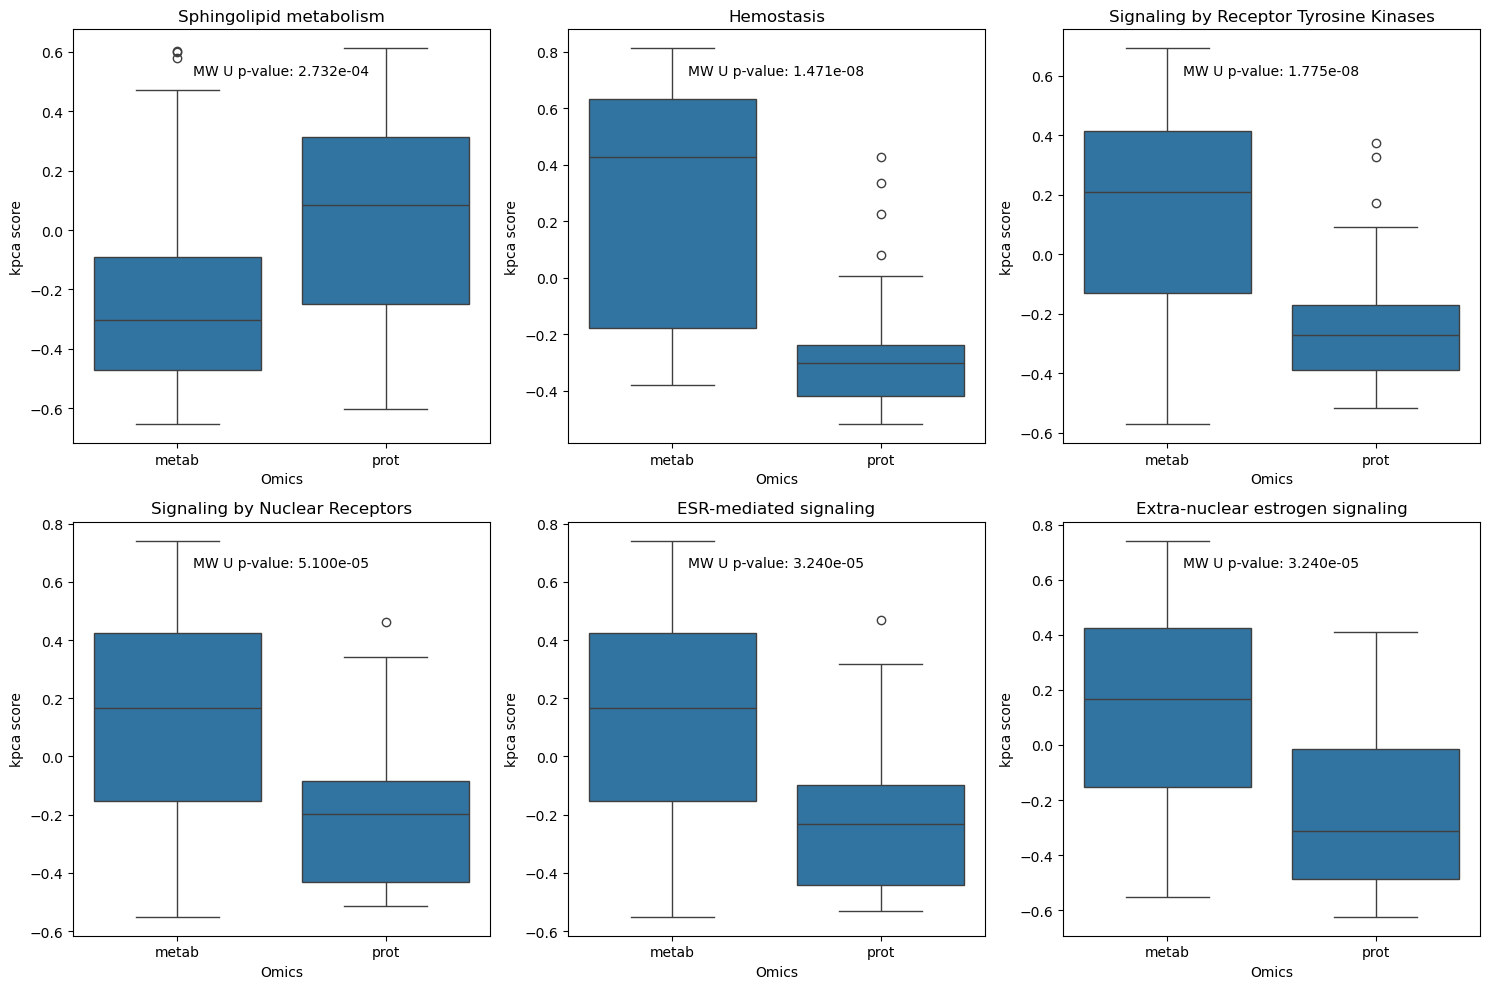

In [ ]:
from scipy.stats import mannwhitneyu

plt.figure(figsize=(15, 5))
n_plots = len(parafac2_common_metab_sigpath_dict.keys())
n_cols = 3
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes if there are multiple rows
if n_rows > 1:
    axes = axes.flatten()

# Set y-axis labels for each row
y_labels = ['kpca score'] * n_rows  # You can customize this if needed

for i, (pathid, pathname) in enumerate(parafac2_common_metab_sigpath_dict.items()):
    data = {
        'metab': metab_filtered_kpca.loc[mild_ind, pathid],
        'prot': prot_filtered_kpca.loc[mild_ind, pathid]
    }
    df = pd.DataFrame(data)
    df_melted = df.melt(var_name='Omics', value_name='kpca score')
    
    # Create boxplot
    sns.boxplot(x='Omics', y='kpca score', data=df_melted, ax=axes[i])
    
    axes[i].set_title(f'{pathname}')  
    axes[i].set_xlabel('Omics')
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(df['metab'], df['prot'], alternative='two-sided')
    
    # Annotate p-value on the plot
    axes[i].text(0.5, 0.9, f'MW U p-value: {p_value:.3e}', ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    # Set y-axis label only for the first column of each row
    if i % n_cols == 0:
        axes[i].set_ylabel(y_labels[i // n_cols])

# Hide any unused subplots
for j in range(n_plots, n_rows * n_cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1500x500 with 0 Axes>

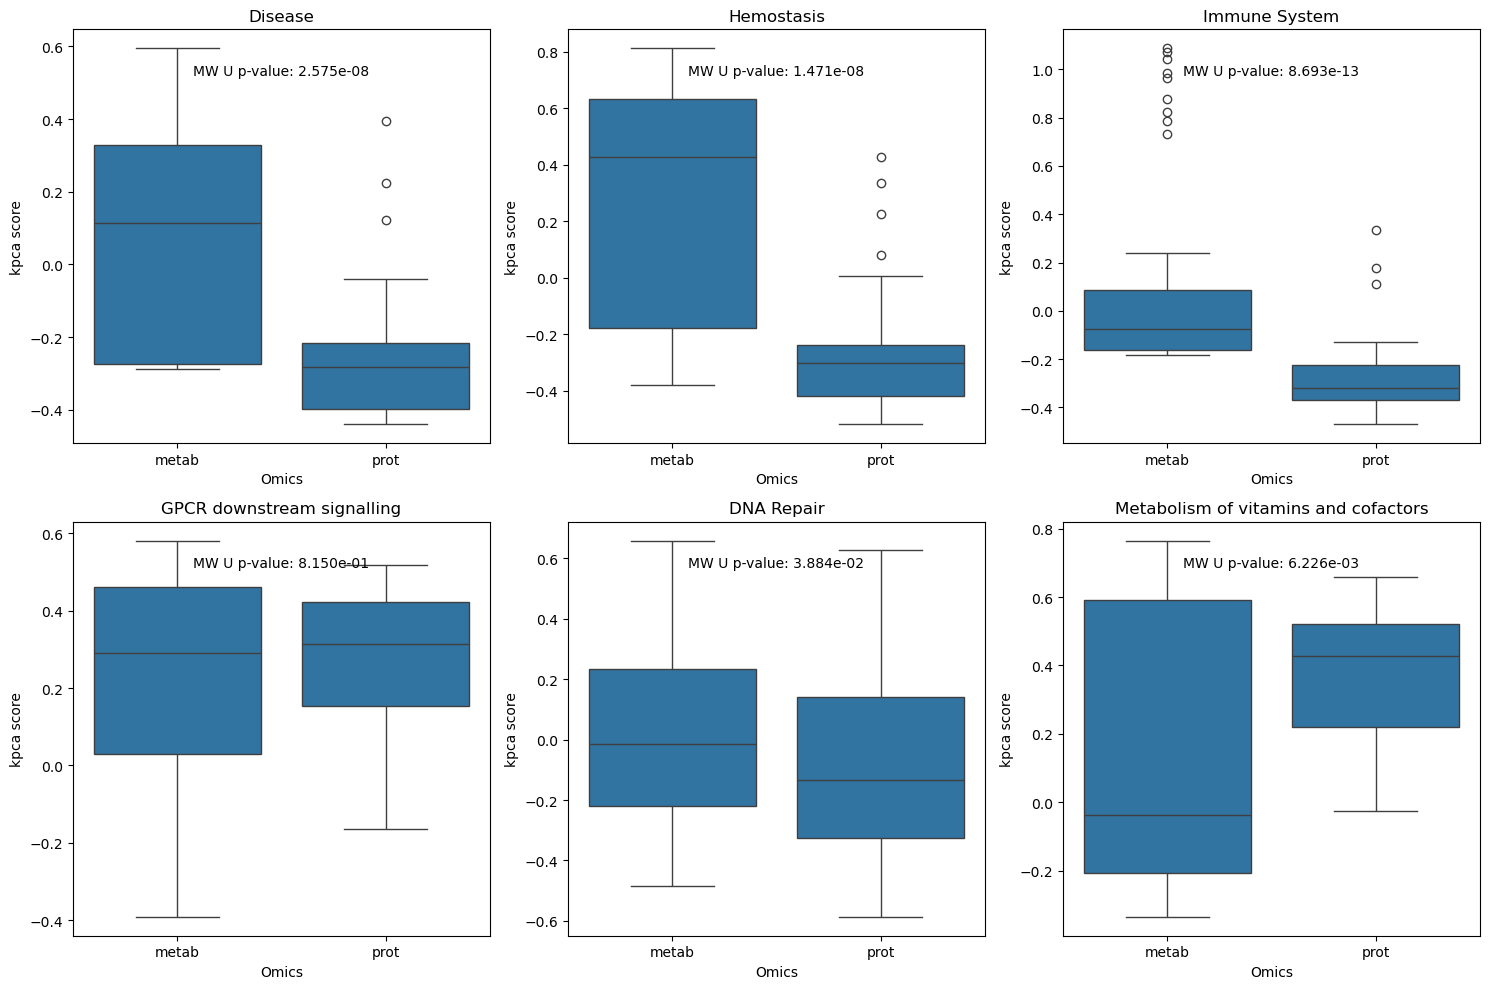

In [144]:
from scipy.stats import mannwhitneyu

plt.figure(figsize=(15, 5))
n_plots = len(parafac2_common_prot_sigpath_dict.keys())
n_cols = 3
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes if there are multiple rows
if n_rows > 1:
    axes = axes.flatten()

# Set y-axis labels for each row
y_labels = ['kpca score'] * n_rows  # You can customize this if needed

for i, (pathid, pathname) in enumerate(parafac2_common_prot_sigpath_dict.items()):
    data = {
        'metab': metab_filtered_kpca.loc[mild_ind, pathid],
        'prot': prot_filtered_kpca.loc[mild_ind, pathid]
    }
    df = pd.DataFrame(data)
    df_melted = df.melt(var_name='Omics', value_name='kpca score')
    
    # Create boxplot
    sns.boxplot(x='Omics', y='kpca score', data=df_melted, ax=axes[i])
    
    axes[i].set_title(f'{pathname}')  
    axes[i].set_xlabel('Omics')
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(df['metab'], df['prot'], alternative='two-sided')
    
    # Annotate p-value on the plot
    axes[i].text(0.5, 0.9, f'MW U p-value: {p_value:.3e}', ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    # Set y-axis label only for the first column of each row
    if i % n_cols == 0:
        axes[i].set_ylabel(y_labels[i // n_cols])

# Hide any unused subplots
for j in range(n_plots, n_rows * n_cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

plt.figure(figsize=(15, 5))
n_plots = len(parafac2_common_metab_sigpath_dict.keys())
n_cols = 3
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes if there are multiple rows
if n_rows > 1:
    axes = axes.flatten()

# Set y-axis labels for each row
y_labels = ['kpca score'] * n_rows  # You can customize this if needed

for i, (pathid, pathname) in enumerate(parafac2_common_metab_sigpath_dict.items()):
    data = {
        'metab': metab_filtered_kpca.loc[mild_ind, pathid],
        'prot': prot_filtered_kpca.loc[mild_ind, pathid]
    }
    df = pd.DataFrame(data)
    df_melted = df.melt(var_name='Omics', value_name='kpca score')
    
    # Create boxplot
    sns.boxplot(x='Omics', y='kpca score', data=df_melted, ax=axes[i])
    
    axes[i].set_title(f'{pathname}')  
    axes[i].set_xlabel('Omics')
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(df['metab'], df['prot'], alternative='two-sided')
    
    # Annotate p-value on the plot
    axes[i].text(0.5, 0.9, f'MW U p-value: {p_value:.3e}', ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    # Set y-axis label only for the first column of each row
    if i % n_cols == 0:
        axes[i].set_ylabel(y_labels[i // n_cols])

# Hide any unused subplots
for j in range(n_plots, n_rows * n_cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [56]:
with open('p1_pseudoz_rank.pkl','rb') as f:
    p1_pseudoz_rank = pickle.load(f)

- combined p value

In [60]:
metab_empirical_test = harmonic_pvalue(metab_facs_bs)
count_significant = (metab_empirical_test['Harmonic'] < 0.05).sum()

print(f"Number of metabolomics pathways with combined p-value < 0.05: {count_significant}")

Number of metabolomics pathways with combined p-value < 0.05: 43


In [61]:
metab_empirical_test.sort_values(by='Harmonic',ascending=True)

,Factor 1,Factor 2,Harmonic
R-HSA-109582,0.000300,0.026497,0.000593
R-HSA-418555,0.000300,0.026797,0.000593
R-HSA-9662851,0.000300,0.026797,0.000593
R-HSA-9664433,0.000300,0.026797,0.000593
R-HSA-9658195,0.000300,0.026797,0.000593
R-HSA-112315,0.000300,0.026997,0.000593
R-HSA-112316,0.000300,0.026997,0.000593
R-HSA-5663205,0.000300,0.027797,0.000594
R-HSA-428157,0.000300,0.028097,0.000594
R-HSA-9006931,0.000300,0.028197,0.000594


In [62]:
prot_empirical_test = harmonic_pvalue(prot_facs_bs)

count_significant = (prot_empirical_test['Harmonic'] < 0.05).sum()
print(f"Number of proteomics pathways with combined p-value < 0.05: {count_significant}")

Number of proteomics pathways with combined p-value < 0.05: 53


In [63]:
prot_empirical_test.sort_values(by='Harmonic',ascending=True)

,Factor 1,Factor 2,Harmonic
R-HSA-1428517,0.000300,0.028097,0.000594
R-HSA-70268,0.000300,0.028097,0.000594
R-HSA-388396,0.000300,0.028697,0.000594
R-HSA-5668914,0.000300,0.028797,0.000594
R-HSA-372790,0.000300,0.029097,0.000594
R-HSA-373076,0.000300,0.029297,0.000594
R-HSA-112316,0.000300,0.029497,0.000594
R-HSA-112315,0.000300,0.029497,0.000594
R-HSA-500792,0.000300,0.029497,0.000594
R-HSA-1852241,0.000300,0.029697,0.000594


In [64]:
metab_sigpath = list(metab_empirical_test.index[metab_empirical_test['Harmonic'] < 0.05])

In [65]:
prot_sigpath = list(prot_empirical_test.index[prot_empirical_test['Harmonic'] < 0.05])

In [66]:
parafac2_common_sigpath = list(set(metab_sigpath + prot_sigpath))

In [67]:
with open('parafac2_common_sigpath.pkl', 'wb') as f:
    pickle.dump(parafac2_common_sigpath, f)